In [23]:
pip install scikit-optimize tune-sklearn



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
# Standard Libraries
import os
import logging
import warnings
import time
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from joblib import dump, load
from sklearn.model_selection import (train_test_split, RandomizedSearchCV,
                                        StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Ensemble Methods
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                                 AdaBoostClassifier, ExtraTreesClassifier,
                                 HistGradientBoostingClassifier, StackingClassifier,
                                 VotingClassifier, BaggingClassifier)

# Neural Networks and Tree-Based Models
from sklearn.linear_model import (LogisticRegression, PassiveAggressiveClassifier, 
                                    SGDClassifier, RidgeClassifier, Perceptron)  
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Neighbors and Naive Bayes
from sklearn.neighbors import (KNeighborsClassifier, NearestCentroid, 
                               RadiusNeighborsClassifier)
from sklearn.naive_bayes import BernoulliNB, GaussianNB

# Metrics
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                                recall_score, f1_score, confusion_matrix,
                                classification_report, precision_recall_curve,
                                roc_curve)

# Tree Models
from sklearn.tree import DecisionTreeClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Statistical Models
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                            QuadraticDiscriminantAnalysis)

# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# Statistics
from scipy import stats

# SHAP for model interpretation
import shap
# Import necessary libraries
import os
import logging
from joblib import dump
from sklearn.ensemble import (
    StackingClassifier,
    VotingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [25]:

# Suppress warnings
warnings.filterwarnings("ignore")

# Configure logging with timestamp
log_filename = f'model_performance_{pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")}.log'
logging.basicConfig(filename=log_filename, level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
DATASET_PATH = 'E:/projects/Heart_Attack_Prediction/heart.csv'
MODEL_SAVE_PATH = 'E:/projects/Heart_Attack_Prediction/models'
PREPROCESSOR_PATH = os.path.join(MODEL_SAVE_PATH, 'preprocessor.pkl')
VISUALIZATION_PATH = 'E:/projects/Heart_Attack_Prediction/visualizations'


In [26]:
# Load the dataset
df = pd.read_csv(DATASET_PATH)
logging.info("Dataset loaded successfully.")
print("Dataset loaded successfully.")

def data_description(df):
    logging.info("=== Data Description ===")
    print("=== Data Description ===")
    logging.info(df.info())
    print(df.info())

    logging.info("\n=== Summary Statistics ===")
    print("\n=== Summary Statistics ===")
    logging.info(df.describe())
    print(df.describe())

    logging.info("\n=== Missing Values ===")
    print("\n=== Missing Values ===")
    logging.info(df.isnull().sum())
    print(df.isnull().sum())

    logging.info("\n=== Unique Values in Each Column ===")
    print("\n=== Unique Values in Each Column ===")
    for column in df.columns:
        unique_values = df[column].nunique()
        logging.info(f"{column}: {unique_values} unique values")
        print(f"{column}: {unique_values} unique values")

data_description(df)

def explore_data(df):
    logging.info("Exploring data...")
    print("Exploring data...")
    logging.info(f"Data Summary:\n{df.describe()}")
    print(f"Data Summary:\n{df.describe()}")

    # Target Distribution
    plt.figure(figsize=(8, 4))
    sns.countplot(x='output', data=df)
    plt.title('Target Distribution')
    plt.xlabel('Output (0: No Heart Attack, 1: Heart Attack)')
    plt.ylabel('Count')
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'target_distribution.png'))
    plt.close()
    print("Saved target distribution plot.")

    # Box Plots for Numerical Features
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df.select_dtypes(include=[np.number]), orient='h')
    plt.title('Box Plots for Numerical Features')
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'box_plots.png'))
    plt.close()
    print("Saved box plots for numerical features.")

    # Violin Plots for each numerical column
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for column in numerical_columns:
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='output', y=column, data=df)
        plt.title(f'{column} Distribution by Heart Attack Status')
        plt.savefig(os.path.join(VISUALIZATION_PATH, f'{column}_violin_plot.png'))
        plt.close()
        print(f"Saved {column} violin plot.")

    # Joint Plot of Age and Cholesterol
    plt.figure(figsize=(8, 6))
    sns.jointplot(x='age', y='chol', data=df, kind='scatter', hue='output')
    plt.title('Joint Plot of Age and Cholesterol')
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'age_chol_jointplot.png'))
    plt.close()
    print("Saved joint plot of Age and Cholesterol.")

    # Boxen Plot for Age Distribution
    plt.figure(figsize=(12, 6))
    sns.boxenplot(x='output', y='age', data=df)
    plt.title('Age Distribution by Heart Attack Status (Boxen Plot)')
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'age_boxen_plot.png'))
    plt.close()
    print("Saved age distribution boxen plot.")

    # Categorical Features Distribution
    categorical_columns = ['sex', 'cp', 'restecg', 'slp', 'caa', 'thall']
    for column in categorical_columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=column, hue='output', data=df)
        plt.title(f'Distribution of {column} by Heart Attack Status')
        plt.savefig(os.path.join(VISUALIZATION_PATH, f'distribution_{column}.png'))
        plt.close()
        print(f"Saved distribution plot for {column}.")

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap')
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'correlation_heatmap.png'))
    plt.close()
    print("Saved correlation heatmap.")

    # Missing Values
    missing_values = df.isnull().sum()
    logging.info(f"Missing values in each column:\n{missing_values[missing_values > 0]}")
    print(f"Missing values in each column:\n{missing_values[missing_values > 0]}")

explore_data(df)

def preprocess_data(df):
    # Define features and target
    X = df.drop('output', axis=1)
    y = df['output']

    # Calculate z-scores
    z_scores = np.abs(stats.zscore(X))
    threshold = 3
    outliers = (z_scores > threshold).any(axis=1)

    # Log and print the number of detected outliers
    outlier_count = outliers.sum()
    total_instances = len(X)
    logging.info(f"Detected {outlier_count} outliers out of {total_instances} instances. Removing outliers...")
    print(f"Detected {outlier_count} outliers out of {total_instances} instances. Removing outliers...")

    # Remove outliers
    X_clean = X[~outliers]
    y_clean = y[~outliers]

    # Define numerical and categorical columns
    numerical_cols = X_clean.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_clean.select_dtypes(exclude=[np.number]).columns.tolist()

    # Create transformers for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a single preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Fit the preprocessor to the data
    preprocessor.fit(X_clean)

    # Save the preprocessor for future use
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    dump(preprocessor, PREPROCESSOR_PATH)
    logging.info(f"Preprocessor saved to {PREPROCESSOR_PATH}")
    print(f"Preprocessor saved to {PREPROCESSOR_PATH}")

    # Transform the features
    X_transformed = preprocessor.transform(X_clean)
    logging.info(f"Transformed feature shape: {X_transformed.shape}")
    print(f"Transformed feature shape: {X_transformed.shape}")

    return X_transformed, y_clean

# Preprocess the data
X, y = preprocess_data(df)


Dataset loaded successfully.
=== Data Description ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    ------

<Figure size 800x600 with 0 Axes>

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [28]:
def handle_class_imbalance(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Log and print the completion of SMOTE
    logging.info("Class imbalance handled using SMOTE.")
    print("Class imbalance handled using SMOTE.")

    return X_resampled, y_resampled

# Assuming X_train and y_train are already defined
X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train)


Class imbalance handled using SMOTE.


In [29]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Directory paths (ensure they are set up)
VISUALIZATION_PATH = 'visualizations'
MODEL_SAVE_PATH = 'models'

# Create the directories if they don't exist
os.makedirs(VISUALIZATION_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

In [30]:
# Function to create and tune models
def create_and_tune_models(X_train, y_train):
    models = {
        'random_forest': RandomForestClassifier(),
        'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'catboost': CatBoostClassifier(verbose=0),
        'lightgbm': LGBMClassifier(),
        'svc': SVC(probability=True),
        'logistic_regression': LogisticRegression(),
        'lasso_logistic': LogisticRegression(penalty='l1', solver='liblinear'),
        'lda': LinearDiscriminantAnalysis(),
        'gradient_boosting': GradientBoostingClassifier(),
        'adaboost': AdaBoostClassifier(),
        'extra_trees': ExtraTreesClassifier(),
        'hist_gradient_boosting': HistGradientBoostingClassifier(),
        
    }

    param_dist = {
        'random_forest': {'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 10, 20, 30]},
        'xgboost': {'n_estimators': [50, 100, 150], 'max_depth': [3, 4, 5, 6]},
        'catboost': {'iterations': [100, 200], 'depth': [3, 4, 5]},
        'lightgbm': {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5]},
        'svc': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'logistic_regression': {'C': [0.1, 1, 10]},
        'lasso_logistic': {'C': [0.1, 1, 10]},
        'lda': {'solver': ['svd', 'lsqr']},
        'gradient_boosting': {'n_estimators': [50, 100], 'max_depth': [3, 4, 5]},
        'adaboost': {'n_estimators': [50, 100]},
        'extra_trees': {'n_estimators': [50, 100, 150]},
        'hist_gradient_boosting': {'max_iter': [100, 200]},
        
    }

    tuned_models = {}
    for name, model in models.items():
        try:
            logging.info(f"Tuning {name}...")
            start_time = time.time()  # Start time tracking
            search = RandomizedSearchCV(model, param_distributions=param_dist[name],
                                        n_iter=10, scoring='roc_auc', cv=3, verbose=0, n_jobs=-1)
            search.fit(X_train, y_train)
            tuned_models[name] = search.best_estimator_
            elapsed_time = time.time() - start_time  # End time tracking
            logging.info(f"Best parameters for {name}: {search.best_params_} (Tuning time: {elapsed_time:.2f}s)")
        except Exception as e:
            logging.error(f"Error tuning model {name}: {e}")

    return tuned_models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = np.zeros((y_pred.shape[0], 2))  # Placeholder if predict_proba isn't available

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1 Score': f1_score(y_test, y_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'ROC Curve': roc_curve(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None,
        'Precision-Recall Curve': precision_recall_curve(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None
    }
    return metrics

def evaluate_models(models, X_test, y_test):
    evaluation_results = {}
    for name, model in models.items():
        logging.info(f"Evaluating {name}...")
        metrics = evaluate_model(model, X_test, y_test)

        log_metrics = {
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1 Score'],
            'ROC AUC': metrics['ROC AUC']
        }
        
        logging.info(f"Model: {name}, Accuracy: {log_metrics['Accuracy']:.4f}, "
                     f"Precision: {log_metrics['Precision']:.4f}, Recall: {log_metrics['Recall']:.4f}, "
                     f"F1 Score: {log_metrics['F1 Score']:.4f}, "
                     f"ROC AUC: {log_metrics['ROC AUC']:.4f}" if log_metrics['ROC AUC'] is not None else 
                     f"Model: {name}, Accuracy: {log_metrics['Accuracy']:.4f}, "
                     f"Precision: {log_metrics['Precision']:.4f}, Recall: {log_metrics['Recall']:.4f}, "
                     f"F1 Score: {log_metrics['F1 Score']:.4f}, ROC AUC: Not Available")

        evaluation_results[name] = metrics

        # Save confusion matrix visualization
        cm = metrics['Confusion Matrix']
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.grid(False)  # Disable grid
        plt.savefig(os.path.join(VISUALIZATION_PATH, f'confusion_matrix_{name}.png'))
        plt.close()

        # Save ROC curve visualization if available
        if metrics['ROC Curve'] is not None:
            fpr, tpr, _ = metrics['ROC Curve']
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["ROC AUC"]:.4f})')
            plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
            plt.title(f'ROC Curve for {name}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.grid(True)  # Enable grid for better readability
            plt.legend(loc='lower right')
            plt.savefig(os.path.join(VISUALIZATION_PATH, f'roc_curve_{name}.png'))
            plt.close()

        # Save Precision-Recall curve visualization if available
        if metrics['Precision-Recall Curve'] is not None:
            precision, recall, _ = metrics['Precision-Recall Curve']
            plt.figure(figsize=(6, 4))
            plt.plot(recall, precision, marker='o')
            plt.title(f'Precision-Recall Curve for {name}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid(True)  # Enable grid for better readability
            plt.savefig(os.path.join(VISUALIZATION_PATH, f'precision_recall_curve_{name}.png'))
            plt.close()

    return evaluation_results


In [31]:
import os
import logging
from joblib import dump
from sklearn.ensemble import (
    StackingClassifier, VotingClassifier, GradientBoostingClassifier,
    RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Function to create a voting classifier
def create_voting_classifier(tuned_models, voting_type='soft'):
    estimators = [(name, model) for name, model in tuned_models.items()]
    return VotingClassifier(estimators=estimators, voting=voting_type)

# Function to create a stacking classifier
def create_stacking_classifier(tuned_models, final_estimator=CatBoostClassifier(verbose=0)):
    estimators = [(name, model) for name, model in tuned_models.items()]
    return StackingClassifier(estimators=estimators, final_estimator=final_estimator)

# Define ensemble strategy functions with optional parameters
def create_boosting_classifier(params=None):
    return GradientBoostingClassifier(**(params or {}))

def create_bagging_classifier(estimator=RandomForestClassifier(), params=None):
    return BaggingClassifier(estimator=estimator, **(params or {}))

# Function to fit and evaluate a model
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    try:
        model.fit(X_train, y_train)
        metrics = evaluate_model(model, X_test, y_test)  # Assumes evaluate_model returns metrics
        results_dict[model_name] = metrics
        logging.info(f"Model: {model_name}, Metrics: {metrics}")
    except Exception as e:
        logging.error(f"Error fitting model {model_name}: {e}")

# Assuming X_train, X_test, y_train, and y_test are defined
tuned_models = create_and_tune_models(X_train, y_train)  # Creates and tunes base models
evaluate_results = evaluate_models(tuned_models, X_test, y_test)  # Evaluate individual base models

# Ensemble models
stacking_classifier = create_stacking_classifier(tuned_models, final_estimator=LogisticRegression())
boosting_clf = create_boosting_classifier()
bagging_clf = create_bagging_classifier(estimator=RandomForestClassifier())
voting_clf_soft = create_voting_classifier(tuned_models, voting_type='soft')
voting_clf_hard = create_voting_classifier(tuned_models, voting_type='hard')

# Evaluate ensemble models
for model_name, model in {
    'stacking_classifier': stacking_classifier,
    'boosting_classifier': boosting_clf,
    'bagging_classifier': bagging_clf,
    'voting_classifier_soft': voting_clf_soft,
    'voting_classifier_hard': voting_clf_hard
}.items():
    fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, evaluate_results)

# Function to save models in a single call
def save_models(models_dict, save_path='path_to_save_models'):
    os.makedirs(save_path, exist_ok=True)
    for name, model in models_dict.items():
        dump(model, os.path.join(save_path, f'{name}.joblib'))
        logging.info(f"Saved model: {name} at {save_path}")

# Save individual and ensemble models
save_models({**tuned_models, 'stacking_classifier': stacking_classifier,
             'boosting_classifier': boosting_clf, 'bagging_classifier': bagging_clf,
             'voting_classifier_soft': voting_clf_soft, 'voting_classifier_hard': voting_clf_hard})


[LightGBM] [Info] Number of positive: 126, number of negative: 103
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 229, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550218 -> initscore=0.201553
[LightGBM] [Info] Start training from score 0.201553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g


Model Performance Comparison:
                        Accuracy Precision    Recall  F1 Score   ROC AUC  \
boosting_classifier     0.862069  0.863971  0.856971  0.859394  0.960337   
voting_classifier_soft  0.827586  0.844737  0.814904  0.819876  0.953125   
bagging_classifier      0.862069  0.871212  0.853365  0.857843   0.95012   
catboost                 0.87931  0.895109   0.86899  0.874807  0.949519   
lightgbm                0.862069  0.871212  0.853365  0.857843  0.949519   
random_forest           0.862069  0.871212  0.853365  0.857843  0.946514   
extra_trees              0.87931  0.879394  0.876202  0.877526  0.945312   
stacking_classifier     0.844828  0.857786  0.834135  0.839038   0.94351   
xgboost                 0.810345  0.831984  0.795673  0.800313  0.939904   
logistic_regression     0.810345  0.831984  0.795673  0.800313  0.936298   
adaboost                0.862069  0.871212  0.853365  0.857843  0.930288   
hist_gradient_boosting  0.810345  0.820463  0.799279  0.8

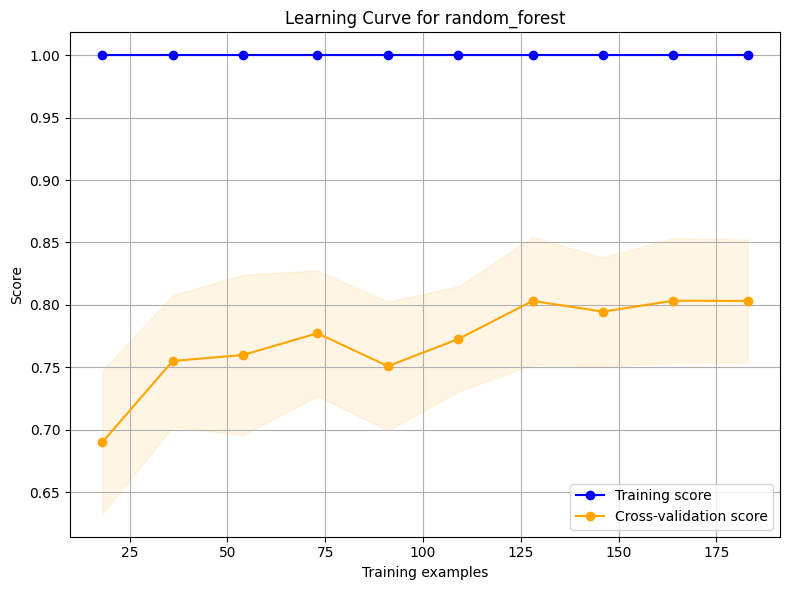

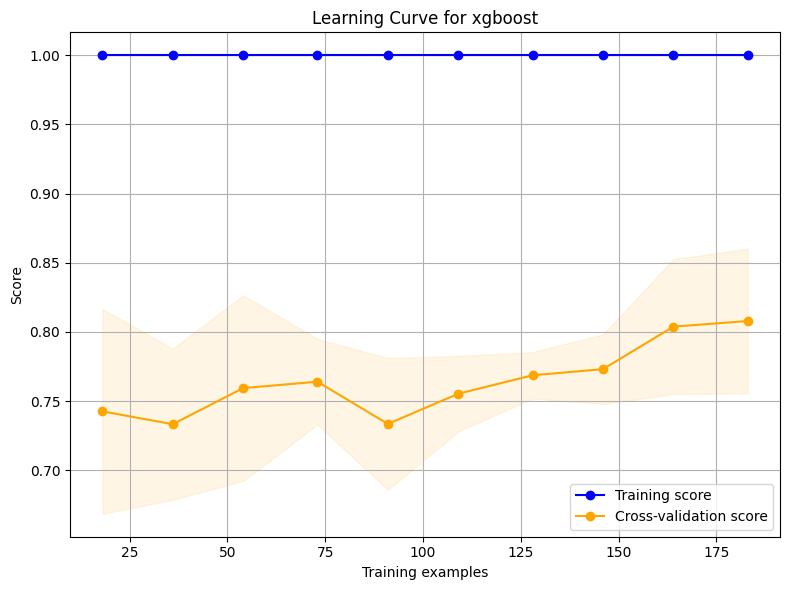

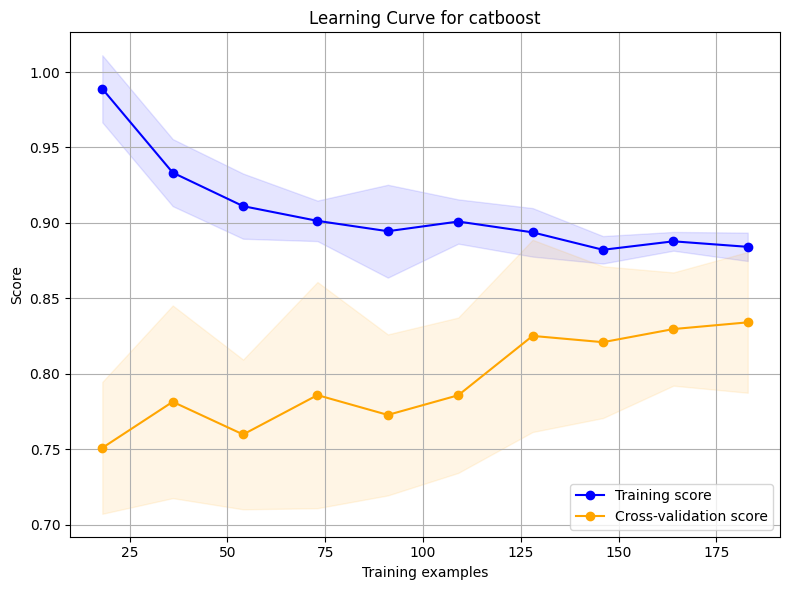

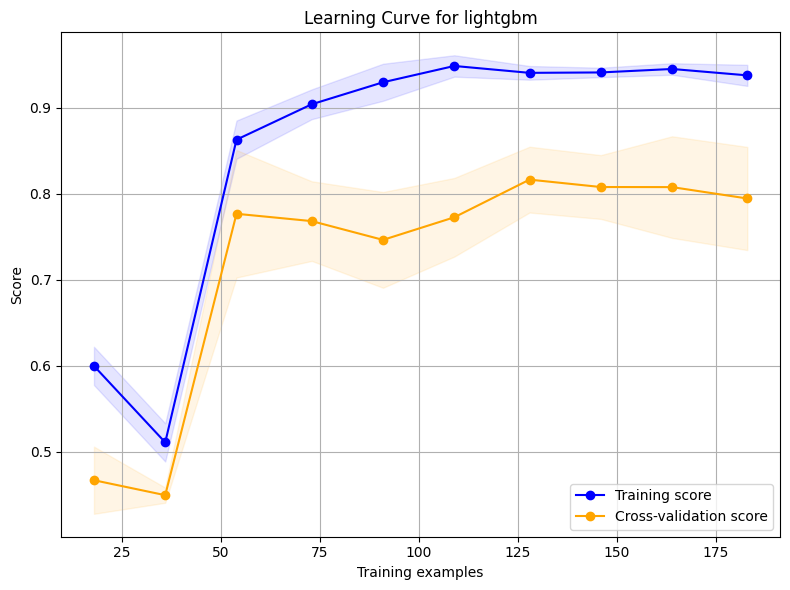

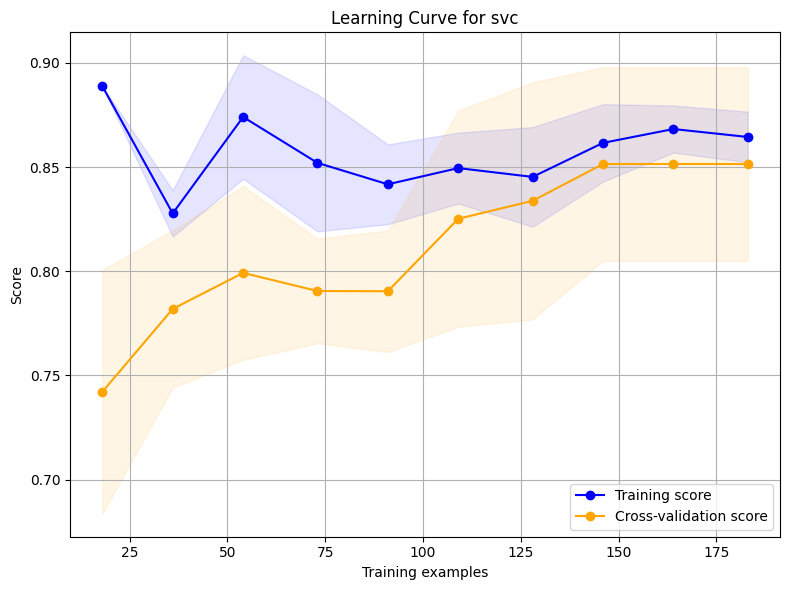

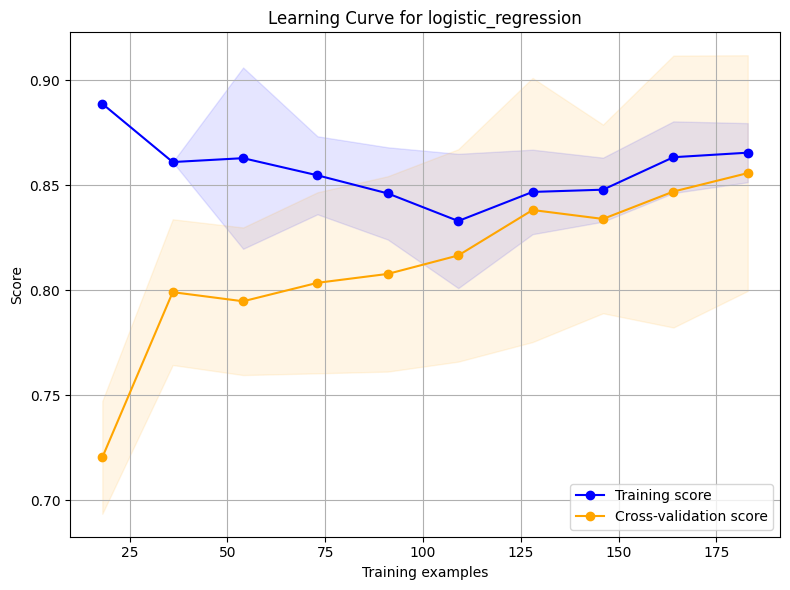

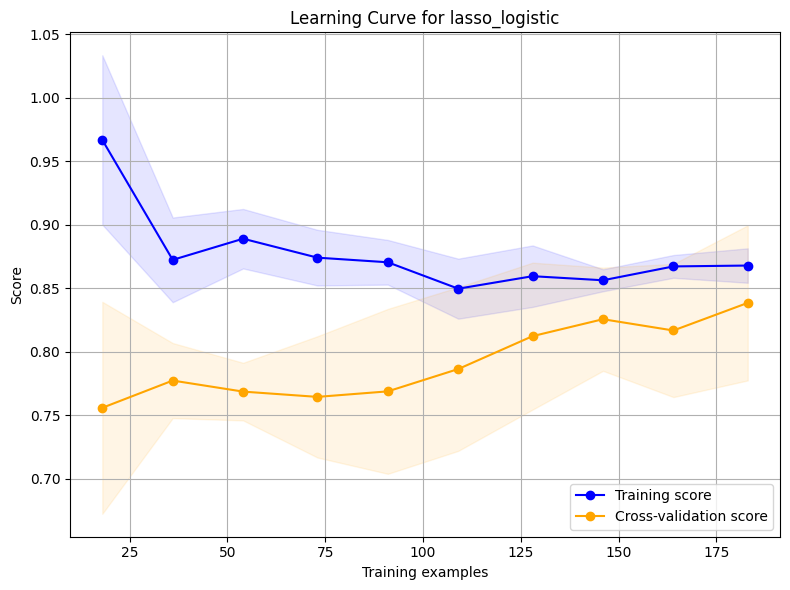

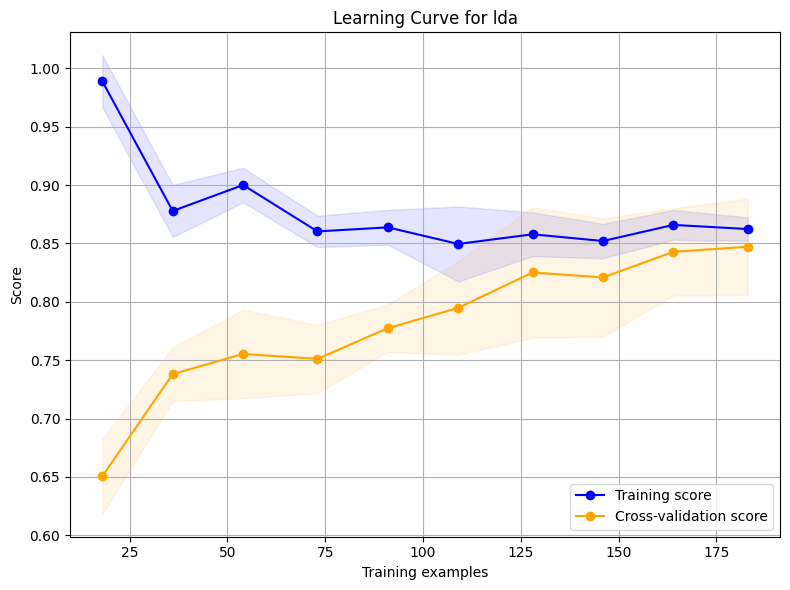

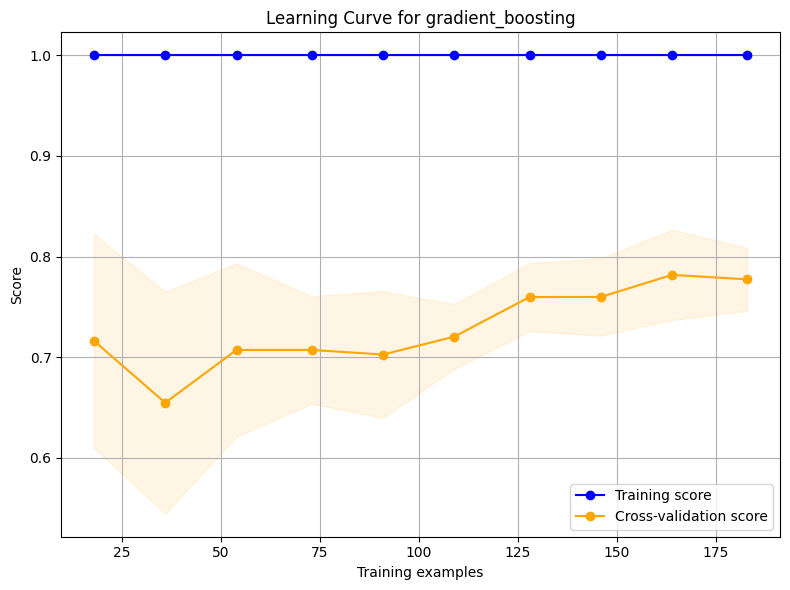

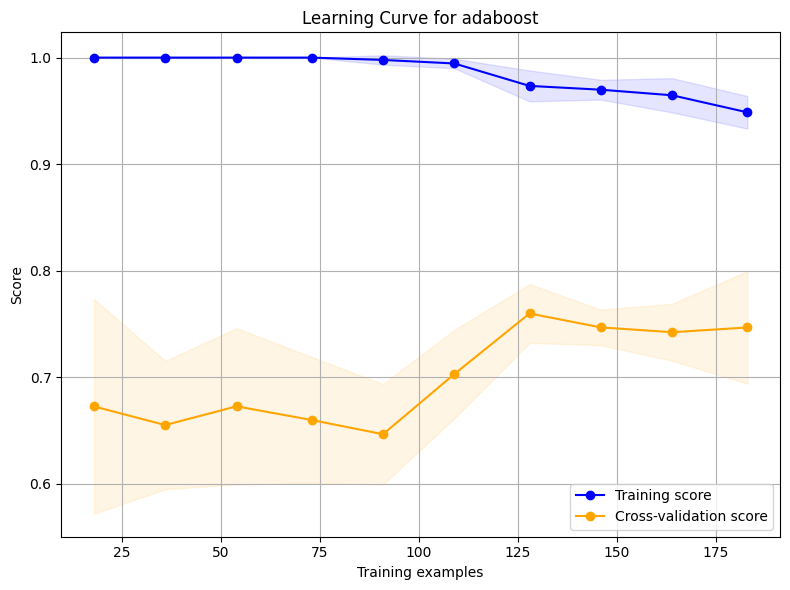

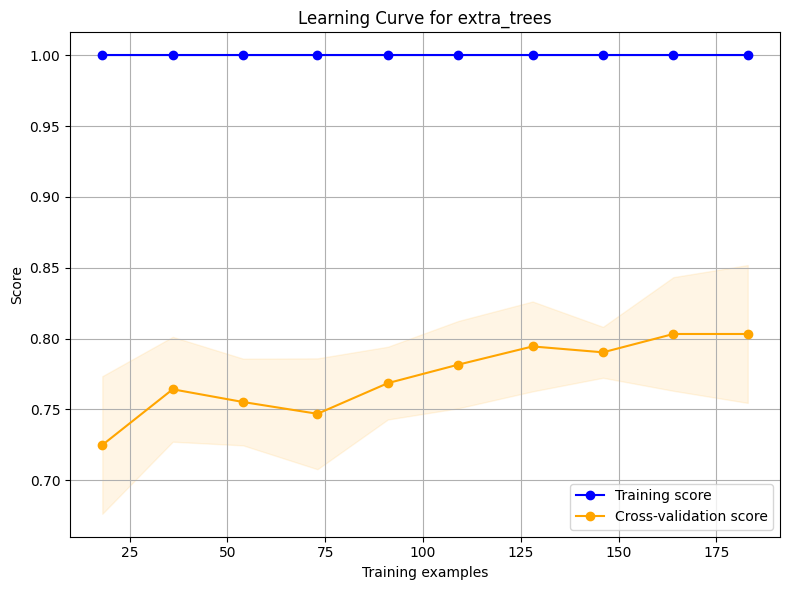

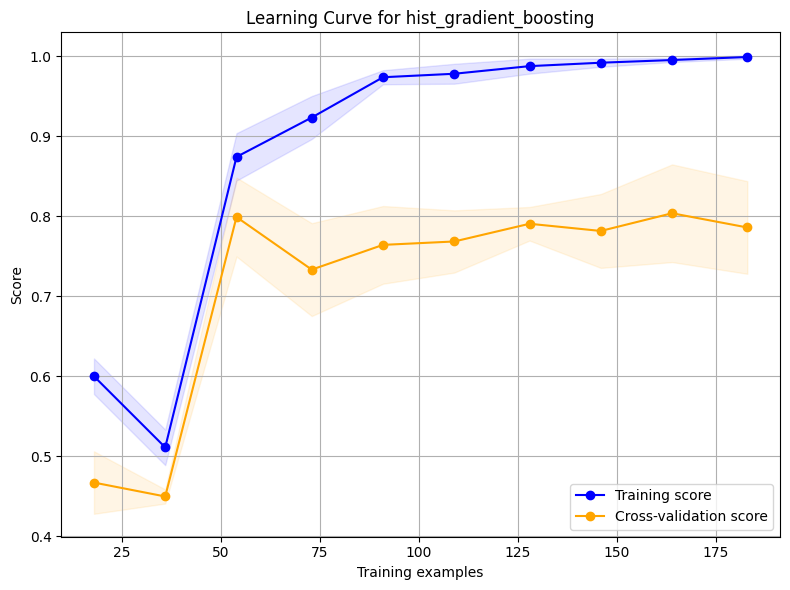

<Figure size 1000x600 with 0 Axes>

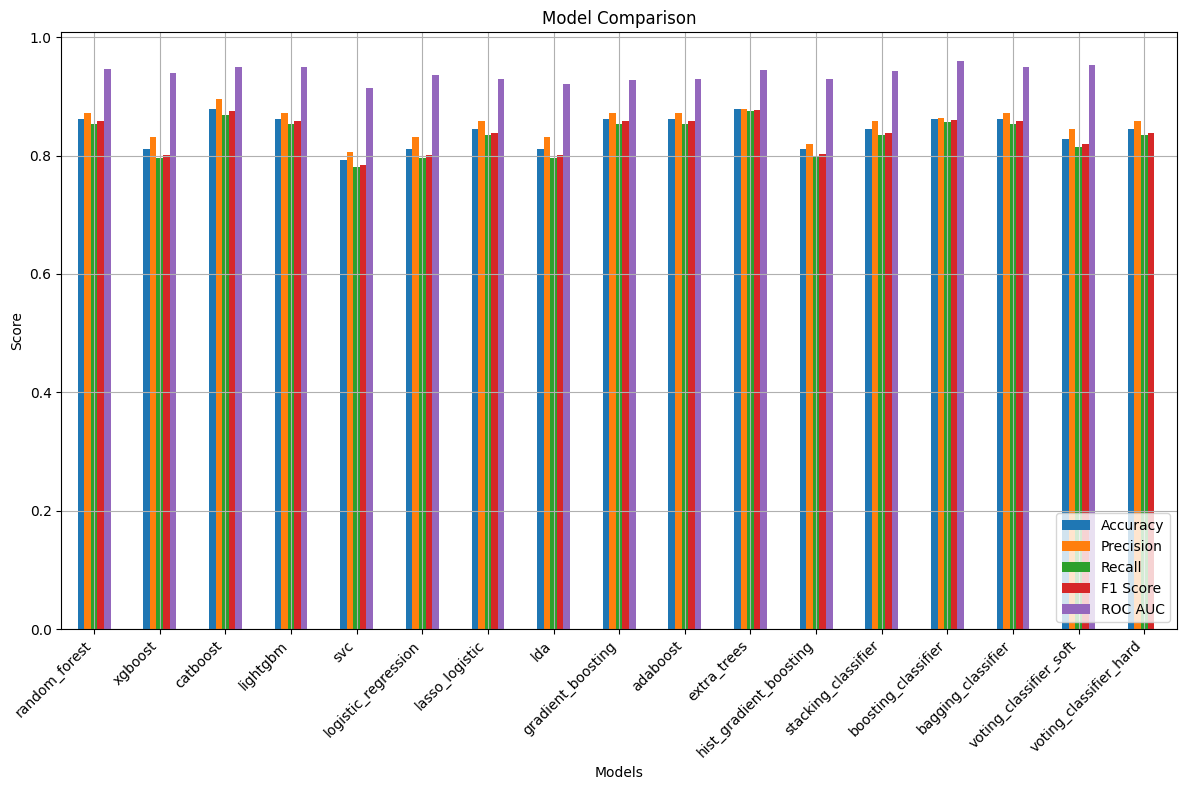

In [32]:

def model_comparison(evaluation_results):
    """
    Compare model performance metrics and save visualizations.

    Parameters:
    - evaluation_results: Dictionary containing performance metrics for each model.
    """
    # Create a DataFrame from the evaluation results for better visualization
    comparison_df = pd.DataFrame(evaluation_results).T  # Transpose to have models as rows

    # Check if 'ROC AUC' is in the DataFrame columns
    if 'ROC AUC' in comparison_df.columns:
        # Sort by ROC AUC as the primary metric
        comparison_df = comparison_df.sort_values(by='ROC AUC', ascending=False)

        # Print the DataFrame with the model comparison
        print("\nModel Performance Comparison:")
        print(comparison_df)

        # Create bar plots for accuracy and F1 Score comparison
        comparison_df[['Accuracy', 'F1 Score']].plot(kind='bar', figsize=(12, 6))
        plt.title('Model Comparison - Accuracy and F1 Score')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(os.path.join(VISUALIZATION_PATH, 'model_comparison_accuracy_f1.png'))
        plt.close()

        # Create a line plot for ROC AUC comparison
        plt.figure(figsize=(12, 6))
        plt.plot(comparison_df.index, comparison_df['ROC AUC'], marker='o')
        plt.title('Model Comparison - ROC AUC')
        plt.ylabel('ROC AUC Score')
        plt.xticks(rotation=45)
        plt.grid()
        plt.tight_layout()
        plt.savefig(os.path.join(VISUALIZATION_PATH, 'model_comparison_roc_auc.png'))
        plt.close()
    else:
        print("ROC AUC metrics are not available in the evaluation results.")

# Call the model_comparison function to execute the comparison
model_comparison(evaluate_results)
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, model_name, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve of a given model.
    """
    plt.figure(figsize=(8, 6))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-validation score')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     alpha=0.1, color='orange')

    plt.title(f'Learning Curve for {model_name}')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid(True)  # Enable grid for better readability
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALIZATION_PATH, f'learning_curve_{model_name}.png'))
    plt.show()

# Call this function for each tuned model
for model_name, model in tuned_models.items():
    plot_learning_curve(model, X_train, y_train, model_name)

def plot_model_comparison(evaluation_results):
    """
    Plots a comparison of accuracy, precision, recall, F1 score, and ROC AUC
    for different models.
    """
    metrics_df = pd.DataFrame({
        model_name: {
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1 Score'],
            'ROC AUC': metrics['ROC AUC'] if metrics['ROC AUC'] is not None else 0
        }
        for model_name, metrics in evaluation_results.items()
    }).T

    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Comparison')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.grid(True)  # Enable grid for better readability
    plt.savefig(os.path.join(VISUALIZATION_PATH, 'model_comparison.png'))
    plt.show()

# Call this function after evaluating the models
plot_model_comparison(evaluate_results)


In [ ]:
import shap
import logging
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Directory for saving visualizations
VISUALIZATION_PATH = "./shap_visualizations"

# Create directory if not exists
if not os.path.exists(VISUALIZATION_PATH):
    os.makedirs(VISUALIZATION_PATH)

# Setup logging for errors
logging.basicConfig(filename='shap_explanation_errors.log', level=logging.ERROR)

# Helper function to save plots
def save_plot(plot_fn, filename):
    try:
        plot_fn()
        plt.savefig(os.path.join(VISUALIZATION_PATH, filename))
        plt.close()
    except Exception as e:
        logging.error(f"Error saving plot {filename}: {e}")
        print(f"Error saving plot {filename}: {e}")

# Model and hyperparameters setup
models = {
    'random_forest': RandomForestClassifier(),
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'catboost': cb.CatBoostClassifier(verbose=0),
    'lightgbm': lgb.LGBMClassifier(),
    'svc': SVC(probability=True),
    'logistic_regression': LogisticRegression(),
    'lasso_logistic': LogisticRegression(penalty='l1', solver='liblinear'),
    'lda': LinearDiscriminantAnalysis(),
    'gradient_boosting': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(),
    'extra_trees': ExtraTreesClassifier(),
    'hist_gradient_boosting': HistGradientBoostingClassifier(),
}

param_dist = {
    'random_forest': {'n_estimators': [100, 200, 300], 'max_depth': [80, 90], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']},
    'xgboost': {'n_estimators': [100, 200, 300], 'max_depth': [80, 90], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]},
    'catboost': {'iterations': [200, 300], 'depth': [80, 90], 'learning_rate': [0.01, 0.05, 0.1], 'l2_leaf_reg': [1, 3, 5]},
    'lightgbm': {'n_estimators': [100, 200, 300], 'max_depth': [80, 90], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [20, 40, 60]},
    'svc': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    'logistic_regression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'lasso_logistic': {'C': [0.1, 1, 10], 'penalty': ['l1']},
    'lda': {'solver': ['svd', 'lsqr', 'eigen']},
    'gradient_boosting': {'n_estimators': [100, 200], 'max_depth': [80, 90], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.8, 1.0]},
    'adaboost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    'extra_trees': {'n_estimators': [100, 200, 300], 'max_depth': [80, 90], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2']},
    'hist_gradient_boosting': {'max_iter': [300, 400, 500], 'max_depth': [80, 90], 'learning_rate': [0.01, 0.05, 0.1], 'max_leaf_nodes': [20, 40, 60]},
}

# Function to create and tune models
def create_and_tune_models(X_train, y_train):
    tuned_models = {}
    for name, model in models.items():
        try:
            logging.info(f"Tuning {name}...")
            start_time = time.time()  # Start time tracking
            search = RandomizedSearchCV(model, param_distributions=param_dist[name], n_iter=10, scoring='roc_auc', cv=3, verbose=0, n_jobs=-1)
            search.fit(X_train, y_train)
            tuned_models[name] = search.best_estimator_
            elapsed_time = time.time() - start_time  # End time tracking
            logging.info(f"Best parameters for {name}: {search.best_params_} (Tuning time: {elapsed_time:.2f}s)")
        except Exception as e:
            logging.error(f"Error tuning model {name}: {e}")

    return tuned_models

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = np.zeros((y_pred.shape[0], 2))  # Placeholder if predict_proba isn't available

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1 Score': f1_score(y_test, y_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'ROC Curve': roc_curve(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None,
        'Precision-Recall Curve': precision_recall_curve(y_test, y_pred_proba[:, 1]) if hasattr(model, "predict_proba") else None
    }
    return metrics

# Function to evaluate multiple models
def evaluate_models(models, X_test, y_test):
    evaluation_results = {}
    for name, model in models.items():
        logging.info(f"Evaluating {name}...")
        metrics = evaluate_model(model, X_test, y_test)
        log_metrics = {
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1 Score': metrics['F1 Score'],
            'ROC AUC': metrics['ROC AUC']
        }
        
        logging.info(f"Model: {name}, Accuracy: {log_metrics['Accuracy']:.4f}, "
                     f"Precision: {log_metrics['Precision']:.4f}, Recall: {log_metrics['Recall']:.4f}, "
                     f"F1 Score: {log_metrics['F1 Score']:.4f}, "
                     f"ROC AUC: {log_metrics['ROC AUC']:.4f}" if log_metrics['ROC AUC'] is not None else 
                     f"Model: {name}, Accuracy: {log_metrics['Accuracy']:.4f}, "
                     f"Precision: {log_metrics['Precision']:.4f}, Recall: {log_metrics['Recall']:.4f}, "
                     f"F1 Score: {log_metrics['F1 Score']:.4f}, ROC AUC: Not Available")

        evaluation_results[name] = metrics

        # Save confusion matrix visualization
        cm = metrics['Confusion Matrix']
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.grid(False)  # Disable grid
        plt.savefig(os.path.join(VISUALIZATION_PATH, f'confusion_matrix_{name}.png'))
        plt.close()

        # Save ROC curve visualization if available
        if metrics['ROC Curve'] is not None:
            fpr, tpr, _ = metrics['ROC Curve']
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {metrics["ROC AUC"]:.2f})')
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {name}')
            plt.legend(loc='lower right')
            save_plot(plt.show, f'roc_curve_{name}.png')

        # Save Precision-Recall curve visualization if available
        if metrics['Precision-Recall Curve'] is not None:
            precision, recall, _ = metrics['Precision-Recall Curve']
            plt.figure(figsize=(6, 4))
            plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {name}')
            plt.legend(loc='lower left')
            save_plot(plt.show, f'precision_recall_curve_{name}.png')

    return evaluation_results

# Split data
# Assume you have loaded your data in 'X' and 'y' variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE (optional)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create and tune models
tuned_models = create_and_tune_models(X_train_resampled, y_train_resampled)

# Evaluate models
evaluation_results = evaluate_models(tuned_models, X_test, y_test)

# SHAP explanations
for name, model in tuned_models.items():
    try:
        explainer = shap.TreeExplainer(model) if hasattr(model, "feature_importances_") else shap.KernelExplainer(model.predict, X_train)
        shap_values = explainer.shap_values(X_test)
        save_plot(lambda: shap.summary_plot(shap_values, X_test), f"shap_summary_{name}.png")
        save_plot(lambda: shap.dependence_plot(0, shap_values, X_test), f"shap_dependence_{name}_0.png")
    except Exception as e:
        logging.error(f"Error generating SHAP values for {name}: {e}")

